In [17]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import dlc_practical_prologue as prologue

In [18]:
### ONLY FOR THE ANALYSES OF THE RESULTS
import numpy as np
import matplotlib.pyplot as plt

Generate pairs

In [19]:
N = 1000 #nb of pairs
print_errors = False

In [20]:
def reshape_targets(train_target, test_target):
    new_train_target = torch.empty(1000,2)
    new_test_target = torch.empty(1000,2)
    for i in range(1000):
        if train_target[i] == 1 :
            new_train_target[i,0] = 0
            new_train_target[i,1] = 1

        else:
            new_train_target[i,0] = 1
            new_train_target[i,1] = 0

        if test_target[i] == 1:
            new_test_target[i,0] = 0
            new_test_target[i,1] = 1

        else:
            new_test_target[i,0] = 1
            new_test_target[i,1] = 0
    return new_train_target, new_test_target

In [21]:
def create_shallow_model():
    return nn.Sequential(
        nn.Linear(392, 400),
        nn.ReLU(),
        nn.Linear(400, 500),
        nn.ReLU(),
        nn.Linear(500, 600),
        nn.ReLU(),
        nn.Linear(600, 2),
    )

In [22]:
new_train_target = torch.empty(N,2)
new_test_target = torch.empty(N,2)
for i in range(N):
    if train_target[i] == 1 :
        new_train_target[i,0] = 0
        new_train_target[i,1] = 1
        
    else:
        new_train_target[i,0] = 1
        new_train_target[i,1] = 0
        
    if test_target[i] == 1:
        new_test_target[i,0] = 0
        new_test_target[i,1] = 1
        
    else:
        new_test_target[i,0] = 1
        new_test_target[i,1] = 0

In [23]:
class Net(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(392, 784, kernel_size=4)
        self.conv2 = nn.Conv1d(784, 1568, kernel_size=5)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [24]:
def train_model(model, train_input, train_target,lr):
    epoch = 25
    eta = 0.2
    mini_batches = 100
    optimizer = optim.Adam(model.parameters(), lr)
    
    criterion = nn.BCEWithLogitsLoss()
    
    for e in range(epoch):
        sum_loss = 0
        
        for b in range(0, train_input.size(0), mini_batches):
            output = model(train_input.narrow(0, b, mini_batches).reshape(mini_batches, 1, -1))
            loss = criterion(output.squeeze(1), train_target.narrow(0, b, mini_batches))
            loss.requires_grad_()
            model.zero_grad()
            loss.backward()
            optimizer.step()
            sum_loss = sum_loss + loss.item()

In [25]:
def compute_nb_errors(model, test_input, target):
    nb_errors = 0
    mini_batch_size = 100
    
    for b in range(0, test_input.size(0), mini_batch_size):
        output = model(test_input.narrow(0, b, mini_batch_size).reshape(mini_batch_size, 1, -1))
        _, predicted_class = output.max(2)
        for k in range(mini_batch_size):
            
            if target[b + k, predicted_class[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

In [26]:
###ANALYSE THE RESULTS
def analyse_results(train_errors, test_errors, title):
    input_size = 1000
    print('Average train error {:0.2f}% {:0.2f}/{:d}'.format((100 * np.mean(train_errors)) / train_input.size(0),
                                                          np.mean(train_errors), input_size))
    print("Train error standard deviation : {:0.2f}".format(np.std(train_errors)))

    print('Average test error {:0.2f}% {:0.2f}/{:d}'.format((100 * np.mean(test_errors)) / test_input.size(0),
                                                          np.mean(test_errors), input_size))
    print("Test error standard deviation : {:0.2f}".format(np.std(test_errors)))


    train_err = [x*100 / input_size for x in train_errors]
    test_err = [x*100 / input_size for x in test_errors]

    plt.figure
    plt.title(title)
    plt.boxplot([train_err, test_err], labels=['train error', 'test error'])
    plt.ylabel("Error percentage")
    plt.show()

iteration 1/10
iteration 2/10
iteration 3/10
iteration 4/10
iteration 5/10
iteration 6/10
iteration 7/10
iteration 8/10
iteration 9/10
iteration 10/10
Average train error 9.96% 99.60/1000
Train error standard deviation : 37.76
Average test error 24.82% 248.20/1000
Test error standard deviation : 16.15


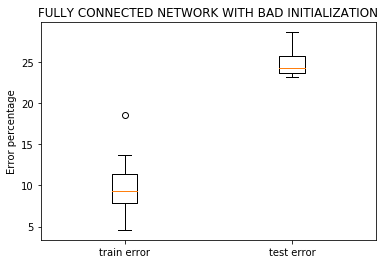

In [27]:
##########################bad initialization (gaussian)
lr = 0.01
mean = 2e-2
std = 1e-1
nb = 10
train_errors = []
test_errors = []

for i in range(nb):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
    #normalize the input
    train_input/=255
    test_input/=255
    new_train_target, new_test_target = reshape_targets(train_target, test_target)
    
    print("iteration {:d}/{:d}".format(i+1,nb))
    model = create_shallow_model()
    with torch.no_grad():
        for p in model.parameters(): p.normal_(mean, std)
            
    train_model(model, train_input, new_train_target, lr)
    nb_train_errors = compute_nb_errors(model, train_input, new_train_target)
    nb_test_errors = compute_nb_errors(model, test_input, new_test_target)
    
    if print_errors:
        print('train error {:0.2f}%% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                           nb_train_errors, train_input.size(0)))

        print('test error {:0.2f}%% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                           nb_test_errors, test_input.size(0)))
    
    train_errors.append(nb_train_errors)
    test_errors.append(nb_test_errors)
    
analyse_results(train_errors, test_errors, "FULLY CONNECTED NETWORK WITH BAD INITIALIZATION")

iteration 1/10
iteration 2/10
iteration 3/10
iteration 4/10
iteration 5/10
iteration 6/10
iteration 7/10
iteration 8/10
iteration 9/10
iteration 10/10
Average train error 3.54% 35.40/1000
Train error standard deviation : 39.86
Average test error 20.74% 207.40/1000
Test error standard deviation : 20.05


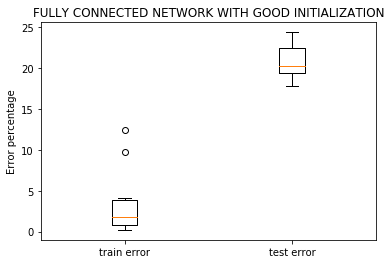

In [33]:
# good result : lr = 0.01 : no overfitting, good test error ~20%
################good initialization (automatic from pytorch)
lr = 0.01
nb = 10
train_errors = []
test_errors = []

for i in range(nb):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
    #normalize the input
    train_input/=255
    test_input/=255
    new_train_target, new_test_target = reshape_targets(train_target, test_target)
    
    model = create_shallow_model()
    train_model(model, train_input, new_train_target, lr)
    nb_train_errors = compute_nb_errors(model, train_input, new_train_target)
    nb_test_errors = compute_nb_errors(model, test_input, new_test_target)
    print("iteration {:d}/{:d}".format(i+1,nb))
    
    if print_errors:
        print('train error {:0.2f}%% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                           nb_train_errors, train_input.size(0)))

        print('test error {:0.2f}%% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                       nb_test_errors, test_input.size(0)))
    
    train_errors.append(nb_train_errors)
    test_errors.append(nb_test_errors)
    
analyse_results(train_errors, test_errors, "FULLY CONNECTED NETWORK WITH GOOD INITIALIZATION")

In [34]:
def train_model_penalties(model, train_input, train_target,lr, L1, value): #L1 = 1 if L1 // =0 if L2
    epoch = 25
    eta = 0.2
    mini_batches = 100
    optimizer = optim.Adam(model.parameters(), lr)
    
    criterion = nn.BCEWithLogitsLoss()
    
    for e in range(epoch):
        sum_loss = 0
        
        for b in range(0, train_input.size(0), mini_batches):
            
            output = model(train_input.narrow(0, b, mini_batches).reshape(mini_batches, 1, -1))
            loss = criterion(output.squeeze(1), train_target.narrow(0, b, mini_batches))
            
            if L1 == 1:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                with torch.no_grad():
                    for p in model.parameters():
                        p.sub_(p.sign() * p.abs().clamp(max = value))

            else:
                for p in model.parameters():
                    sum_loss += value * p.pow(2).sum()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

iteration 1/10
iteration 2/10
iteration 3/10
iteration 4/10
iteration 5/10
iteration 6/10
iteration 7/10
iteration 8/10
iteration 9/10
iteration 10/10
Average train error 7.88% 78.80/1000
Train error standard deviation : 70.28
Average test error 24.80% 248.00/1000
Test error standard deviation : 30.05


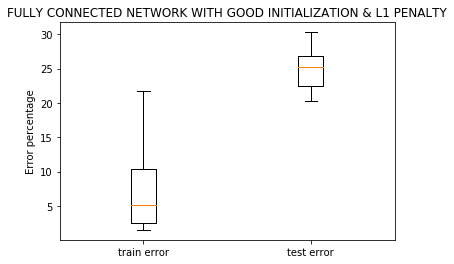

In [36]:
########L1 penalty : good value for L1 : 0.002
lr = 0.01
lambda_l1 = 0.002
nb = 10
train_errors = []
test_errors = []

for i in range(nb):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
    #normalize the input
    train_input/=255
    test_input/=255
    new_train_target, new_test_target = reshape_targets(train_target, test_target)
    
    model = create_shallow_model()
    train_model_penalties(model, train_input, new_train_target, lr, 1, lambda_l1)
    nb_train_errors = compute_nb_errors(model, train_input, new_train_target)
    nb_test_errors = compute_nb_errors(model, test_input, new_test_target)
    
    print("iteration {:d}/{:d}".format(i+1,nb))
    
    if print_errors:
        print('train error {:0.2f}%% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                           nb_train_errors, train_input.size(0)))

        print('test error {:0.2f}%% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                       nb_test_errors, test_input.size(0)))
    
    train_errors.append(nb_train_errors)
    test_errors.append(nb_test_errors)
    
analyse_results(train_errors, test_errors, "FULLY CONNECTED NETWORK WITH GOOD INITIALIZATION & L1 PENALTY")

iteration 1/10
iteration 2/10
iteration 3/10
iteration 4/10
iteration 5/10
iteration 6/10
iteration 7/10
iteration 8/10
iteration 9/10
iteration 10/10
Average train error 1.74% 17.40/1000
Train error standard deviation : 12.59
Average test error 21.43% 214.30/1000
Test error standard deviation : 19.53


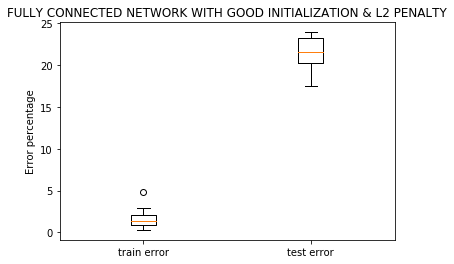

In [38]:
########L2 penalty : good value for L2 : 0.002
lr = 0.01
lambda_l2 = 0.005
nb = 10
train_errors = []
test_errors = []

for i in range(nb):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
    #normalize the input
    train_input/=255
    test_input/=255
    new_train_target, new_test_target = reshape_targets(train_target, test_target)
    
    model = create_shallow_model()
    train_model_penalties(model, train_input, new_train_target, lr, 0, lambda_l2)
    nb_train_errors = compute_nb_errors(model, train_input, new_train_target)
    nb_test_errors = compute_nb_errors(model, test_input, new_test_target)
    
    print("iteration {:d}/{:d}".format(i+1,nb))
    
    if print_errors:
        print('train error {:0.2f}%% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                           nb_train_errors, train_input.size(0)))

        print('test error {:0.2f}%% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                       nb_test_errors, test_input.size(0)))
    
    train_errors.append(nb_train_errors)
    test_errors.append(nb_test_errors)
    
analyse_results(train_errors, test_errors, "FULLY CONNECTED NETWORK WITH GOOD INITIALIZATION & L2 PENALTY")

In [14]:
########L1 penalty : good value for L1 : 0.002
lr = 0.01
for lambda_l1 in [0.001, 0.002, 0.004, 0.005, 0.010, 0.020]:
    model = create_shallow_model()
    train_model_penalties(model, train_input, new_train_target, lr, 1, lambda_l1)
    nb_train_errors = compute_nb_errors(model, train_input, new_train_target)
    nb_test_errors = compute_nb_errors(model, test_input, new_test_target)
    print("L1 :", lambda_l1)
    print('train error {:0.2f}%% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                       nb_train_errors, train_input.size(0)))

    print('test error {:0.2f}%% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                       nb_test_errors, test_input.size(0)))

L1 : 0.001
train error 5.50%% 55/1000
test error 24.10%% 241/1000
L1 : 0.002
train error 7.30%% 73/1000
test error 20.80%% 208/1000
L1 : 0.004
train error 8.80%% 88/1000
test error 21.70%% 217/1000
L1 : 0.005
train error 10.00%% 100/1000
test error 23.20%% 232/1000
L1 : 0.01
train error 44.90%% 449/1000
test error 47.40%% 474/1000
L1 : 0.02
train error 44.90%% 449/1000
test error 47.40%% 474/1000


In [32]:
########L2 penalty : good value for L2 : 0.002
lr = 0.01
for lambda_l2 in [0.001, 0.002, 0.004, 0.005, 0.010, 0.020]:
    model = create_shallow_model()
    train_model_penalties(model, train_input, new_train_target, lr, 0, lambda_l2)
    nb_train_errors = compute_nb_errors(model, train_input, new_train_target)
    nb_test_errors = compute_nb_errors(model, test_input, new_test_target)
    print("L2 :", lambda_l2)
    print('train error {:0.2f}%% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                       nb_train_errors, train_input.size(0)))

    print('test error {:0.2f}%% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                       nb_test_errors, test_input.size(0)))

L2 : 0.001
train error 1.40%% 14/1000
test error 19.60%% 196/1000
L2 : 0.002
train error 1.20%% 12/1000
test error 18.70%% 187/1000
L2 : 0.004
train error 1.00%% 10/1000
test error 21.00%% 210/1000
L2 : 0.005
train error 1.40%% 14/1000
test error 17.70%% 177/1000
L2 : 0.01
train error 1.50%% 15/1000
test error 20.10%% 201/1000
L2 : 0.02
train error 2.00%% 20/1000
test error 21.00%% 210/1000
